# Exact low rank data 

This is the template code to get you started. You should fill out the code for 2 places:
1. direct_solver
2. low_rank_solver

Feel help to write any additional functions and helper code. Note that the data matrix is a 1000 by 1000 matrix with rank 10.

In [12]:
import numpy as np
import scipy.io as sio
import scipy

In [79]:
def rank_decompose(A, r):
    U, s, Vh = np.linalg.svd(A, full_matrices=False)
    return U[:,:r], s[:r], Vh[:r, :]

data = sio.loadmat('low_rank_mtx.mat')
A = data['predictors']
y = data['responses'].T
lmbda = data['penalty_param']

m, n = A.shape

U, s, Vh = rank_decompose(A, np.linalg.matrix_rank(A))
L = U * s
R = Vh.T
print(m,n)
print(L.shape)
print(R.shape)

1000 1000
(1000, 10)
(1000, 10)


In [70]:
def direct_solver(A, y, lmbda):
    '''
    Takes in the data matrix A and vector y, scalar lmbda
    and returns the minimizer for the regularized LS problem
    '''
    return np.linalg.inv((A.T @ A) + np.diag(np.repeat(lmbda, n))) @ A.T @ y

In [76]:
def low_rank_solver(L, R, y, lmbda):
    '''
    Takes in the matrices L and R, with LR^T = A, scalar lmbda,
    and vector y, and returns the minimizer for the low rank
    regularized LS problem
    '''
    A = (L @ R.T) @ R
    int_sol = np.linalg.inv((A.T @ A) + np.diag(np.repeat(lmbda, L.shape[1]))) @ A.T @ y
    return R @ int_sol

In [77]:
# compare their runtime
print('Direct solver:')
%time soln_direct = direct_solver(A, y, lmbda)

print('\nLow rank solver')
%time soln_low_rank = low_rank_solver(L, R, y, lmbda)

Direct solver:
CPU times: user 579 ms, sys: 8.28 ms, total: 587 ms
Wall time: 101 ms

Low rank solver
CPU times: user 11.2 ms, sys: 3.4 ms, total: 14.6 ms
Wall time: 1.88 ms


In [78]:
# check their solutions to be the same (less than 1e-5 is great !)
np.median(np.abs(soln_direct - soln_low_rank) / np.abs(soln_direct))

3.7918204918615135e-12

# Approximate low rank data

For this part, fill out solve_with_rank_r to solve the regularized least square problem by approximating the data matrix with various low rank matrix. Then plot the ranks against the squared error.

In [80]:
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
import math
import scipy.io as sio
import numpy as np
import time
%matplotlib inline

In [81]:
# load in the prepared data
data = sio.loadmat('low_rank_mtx.mat')
A_approx = data['approx_mtx']
n = A_approx.shape[0]
y_appox = data['approx_responses'].T
lmbda = data['penalty_param'][0][0]

In [82]:
def error_fn(A, x, y, lmbda):
    return np.linalg.norm(A @ x - y)**2 + lmbda * np.linalg.norm(x)**2

def rank_decompose(A, r):
    U, s, Vh = np.linalg.svd(A, full_matrices=False)
    return U[:,:r], s[:r], Vh[:r, :]

def rank_decompose_LR(A, r):
    U, s, Vh = rank_decompose(A, r)
    return U * s, Vh

In [83]:
def solve_with_rank_r(A, y, lmbda, r):

    # decompose A
    L, RT = rank_decompose_LR(A, r)
    R = RT.T
    
    #solve using reduced lr method
    soln = low_rank_solver(L, R, y, lmbda)
    
    # compute error
    error = error_fn(A, soln, y, lmbda)
    
    return error

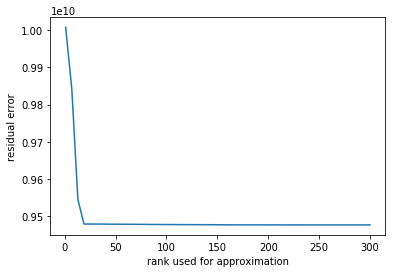

In [85]:
rank_lst = [int(i) for i in np.linspace(1, n)]
error_lst = [solve_with_rank_r(A_approx, y_appox, lmbda, r) for r in rank_lst]
plt.plot(rank_lst, error_lst)
plt.xlabel("rank used for approximation")
plt.ylabel("residual error")
plt.savefig('problem3_plot.png', dpi=300)
plt.show()